In [58]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [118]:
dataset=r'C:\\Users\\ADI\\Desktop\\Jupyter Notebooks\\Minor Project\\datasets\\dataset_photoshop'
imagePaths=list(paths.list_images(dataset))

In [119]:
data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)

In [120]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [121]:
data.shape

(1376, 224, 224, 3)

In [122]:
labels

array(['with mask', 'with mask', 'with mask', ..., 'without mask',
       'without mask', 'without mask'], dtype='<U12')

In [123]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [124]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [125]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [126]:
train_X.shape

(1100, 224, 224, 3)

In [127]:
train_Y.shape

(1100, 2)

In [128]:
test_X.shape

(276, 224, 224, 3)

In [129]:
test_Y.shape

(276, 2)

In [130]:
aug=ImageDataGenerator(rotation_range=20,
                       zoom_range=0.15,
                       width_shift_range=0.2,
                       height_shift_range=0.2,
                       shear_range=0.15,
                       horizontal_flip=True,
                       vertical_flip=True,
                       fill_mode='nearest')

In [133]:
#from keras.applications.mobilenet import MobileNet
#base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3), alpha=1.0, depth_multiplier=1)

In [148]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [149]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [150]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [151]:
for layer in baseModel.layers:
    layer.trainable=False

In [152]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [154]:
learning_rate=0.001
Epochs=20
BS=12

opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)

# serialize the model to disk
print("saving mask model...")
model.save("mask_detector.model", save_format="h5")
#model.save(r'C:\\Users\\ADI\\Desktop\\Jupyter Notebooks\\Minor Project\\mobilenet_v2.model')

Epoch 1/20
91/91 [==============================] - 41s 426ms/step - loss: 0.2190 - accuracy: 0.9498 - val_loss: 0.0640 - val_accuracy: 0.9891
Epoch 2/20
91/91 [==============================] - 38s 417ms/step - loss: 0.0919 - accuracy: 0.9771 - val_loss: 0.0447 - val_accuracy: 0.9819
Epoch 3/20
91/91 [==============================] - 38s 419ms/step - loss: 0.0479 - accuracy: 0.9780 - val_loss: 0.0453 - val_accuracy: 0.9819
Epoch 4/20
91/91 [==============================] - 40s 443ms/step - loss: 0.0327 - accuracy: 0.9910 - val_loss: 0.0550 - val_accuracy: 0.9855
Epoch 5/20
91/91 [==============================] - 38s 421ms/step - loss: 0.0327 - accuracy: 0.9879 - val_loss: 0.0453 - val_accuracy: 0.9783
Epoch 6/20
91/91 [==============================] - 38s 420ms/step - loss: 0.0567 - accuracy: 0.9805 - val_loss: 0.0457 - val_accuracy: 0.9855
Epoch 7/20
91/91 [==============================] - 40s 437ms/step - loss: 0.0407 - accuracy: 0.9854 - val_loss: 0.0326 - val_accuracy: 0.9855

In [155]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

   with mask       0.98      0.99      0.99       138
without mask       0.99      0.98      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



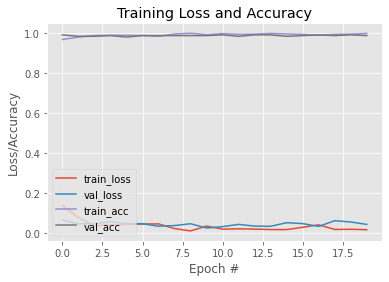

In [156]:
# plot the training loss and accuracy

N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(r'C:\\Users\\ADI\\Desktop\\Jupyter Notebooks\\Minor Project')

In [157]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
from imutils.video import VideoStream
import imutils

In [158]:
def detect_and_predict_mask(frame,faceNet,maskNet):
    #grab the dimensions of the frame and then construct a blob
    (h,w)=frame.shape[:2]
    blob=cv2.dnn.blobFromImage(frame,1.0,(300,300),(104.0,177.0,123.0))
    
    faceNet.setInput(blob)
    detections=faceNet.forward()
    
    #initialize our list of faces, their corresponding locations and list of predictions
    
    faces=[]
    locs=[]
    preds=[]
    
    
    for i in range(0,detections.shape[2]):
        confidence=detections[0,0,i,2]
    
    
        if confidence>0.5:
        #we need the X,Y coordinates
            box=detections[0,0,i,3:7]*np.array([w,h,w,h])
            (startX,startY,endX,endY)=box.astype('int')
        
            #ensure the bounding boxes fall within the dimensions of the frame
            (startX,startY)=(max(0,startX),max(0,startY))
            (endX,endY)=(min(w-1,endX), min(h-1,endY))
        
            #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
            face=frame[startY:endY, startX:endX]
            face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            face=cv2.resize(face,(224,224))
            face=img_to_array(face)
            face=preprocess_input(face)
        
            faces.append(face)
            locs.append((startX,startY,endX,endY))
        
        #only make a predictions if atleast one face was detected
        if len(faces)>0:
            faces=np.array(faces,dtype='float32')
            preds=maskNet.predict(faces,batch_size=12)
        
        return (locs,preds)

In [159]:
prototxtPath=os.path.sep.join([r'C:\\Users\\ADI\\Desktop\\Jupyter Notebooks\\Minor Project','deploy.prototxt'])
weightsPath=os.path.sep.join([r'C:\\Users\\ADI\\Desktop\\Jupyter Notebooks\\Minor Project','res10_300x300_ssd_iter_140000.caffemodel'])

In [160]:
faceNet=cv2.dnn.readNet(prototxtPath,weightsPath)

In [161]:
# load the face mask detector model from disk
maskNet = load_model("mask_detector.model")
#maskNet=load_model(r'C:\\Users\\ADI\\Desktop\\Jupyter Notebooks\\Minor Project\\mask_detector.model')

In [164]:
vs=VideoStream(src=0).start()

while True:
    #grab the frame from the threaded video stream and resize it
    #to have a maximum width of 400 pixels
    frame=vs.read()
    frame=imutils.resize(frame,width=400)
    
    #detect faces in the frame and preict if they are waring masks or not
    (locs,preds)=detect_and_predict_mask(frame,faceNet,maskNet)
    
    #loop over the detected face locations and their corrosponding loactions
    
    for (box,pred) in zip(locs,preds):
        (startX,startY,endX,endY)=box
        (mask,withoutMask)=pred
        
        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)
        
        #display the label and bounding boxes
        cv2.putText(frame,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        
        cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)
        
    #show the output frame
    cv2.imshow("Frame",frame)
    key=cv2.waitKey(1) & 0xFF
    
    if(key==27):
        break
      
cv2.destroyAllWindows()
vs.stop()